In [138]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord


import matplotlib.pyplot as plt
import pandas as pd
import torch

from utils import NAd_tensor
from config import *

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3.5,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Process Data

In [63]:
data = pd.read_csv(f"{DATA}/chimera.csv")
data.head()

,name,aligned_seq,seq,mcherry,mcherry_std,identity,pam,type,expected
0,SpyCas9,TGGFSK-ESIL-------------PK-R-N-----S--D-----KL...,TGGFSKESILPKRNSDKLIARKKDWDPKKYGGFDSPTVAYSVLVVA...,1.000000,0.000000,1.000,NGG,II-A,1
1,Seq1Cas9,NGGLFD-NNIL----------AKPEK-D-D-----K--K-----KL...,NGGLFDNNILAKPEKDDKKKLFPIKNSLSTTSYGGYARATIAYSIL...,-0.000288,0.012243,0.590,NAGA,II-A,0
2,Smu3Cas9,TGGFSK-ESIL-------------PK-G-D-----S--D-----KL...,TGGFSKESILPKGDSDKLIPRKTKKFYWDTKKYGGFDSPIVAYSIL...,1.234746,0.015800,0.648,NGGDT,II-A,1
3,EfaCas9,KGGFSK-ETVE-------------PK-K-D-----S--S-----KL...,KGGFSKETVEPKKDSSKLLPRKNNWDPAKYGGLGSPNVAYTVAFTY...,1.177531,0.020198,0.530,BGGDTNN,II-A,1
4,LrhCas9,--DLFK-QTIYAA-------KDSKER-G-G-----S--K-----QL...,DLFKQTIYAAKDSKERGGSKQLIPKKQGYPTQVYGGYTRENTAYLA...,-0.041357,0.012211,0.279,NNTAAW,II-A,0


In [78]:
seq_cas9 = data.aligned_seq[0]
N = len(data.seq[0])
idx = [i for i, x in enumerate(seq_cas9) if x != "-"]
ids = []
for x in data.aligned_seq:
    sim = 0
    for i, (x_, x_cas9) in enumerate(zip(x, seq_cas9)):
        if i not in idx:
            continue
        if x_ == x_cas9:
            sim+=1
    ids.append(sim/N)
data.identity = ids

In [79]:
def from_df_to_fasta(folder, df, prefix=""):
    records_aligned = []
    records_unaligned = []
    for i, data in enumerate(df.itertuples()):
        records_aligned.append(SeqRecord(Seq(data.aligned_seq), id=(f"{str(data.name)}|{str(data.mcherry)}|{str(data.mcherry_std)}|{str(data.identity)}|{str(data.pam)}|{str(data.expected)}")))
        records_unaligned.append(SeqRecord(Seq(data.seq), id=(f"{str(data.name)}|{str(data.mcherry)}|{str(data.mcherry_std)}|{str(data.identity)}|{str(data.pam)}|{str(data.expected)}")))
    with open(f"{folder}/chimera_aligned.fasta", "w") as handle:
        SeqIO.write(records_aligned, handle, "fasta")
    with open(f"{folder}/chimera_unaligned.fasta", "w") as handle:
        SeqIO.write(records_unaligned, handle, "fasta")

In [80]:
from_df_to_fasta(DATA, data)

## Build Tree

In [123]:
align = AlignIO.read(f'{DATA}/chimera_aligned.fasta','fasta')
for i, a in enumerate(align):
    aa = a.name.split("|")
    align[i].id = f"{aa[0]} (PAM: {aa[4]}) | Id: {int(float(aa[3])*100)}%"
print(align)

Alignment with 11 rows and 736 columns
TGGFSK-ESIL-------------PK-R-N-----S--D-----...YET SpyCas9 (PAM: NGG) | Id: 100%
NGGLFD-NNIL----------AKPEK-D-D-----K--K-----...YET Seq1Cas9 (PAM: NAGA) | Id: 26%
TGGFSK-ESIL-------------PK-G-D-----S--D-----...YET Smu3Cas9 (PAM: NGGDT) | Id: 57%
KGGFSK-ETVE-------------PK-K-D-----S--S-----...YET EfaCas9 (PAM: BGGDTNN) | Id: 44%
--DLFK-QTIYAA-------KDSKER-G-G-----S--K-----...L-- LrhCas9 (PAM: NNTAAW) | Id: 19%
KGQLFN-LTIK----------DKTQL-K-K-----N--V-----...FV- TbaCas9 (PAM: NNNATTT) | Id: 21%
TGGFSK-ESIL-------------SK-R-E-----S--A-----...YET ScCas9 (PAM: NNG) | Id: 52%
NGGLFD-DNPK-----------SPLE-V-T-----P--S-----...YET SmacCas9 (PAM: NAAN) | Id: 34%
-GGFSD-EMLV-------------PK-S-D-----S--G-----...YET LanCas9 (PAM: NRG) | Id: 37%
KGELFN-ATIA----------GKKDY-K-K-----G--K-----...YEK FmaCas9 (PAM: NNGAC) | Id: 14%
KGEFSK-ATIK-------------PK-G-N-----S--S-----...YE- LmoCas9 (PAM: NGG) | Id: 44%


In [128]:
calculator = DistanceCalculator('blosum62')
distMatrix = calculator.get_distance(align)

constructor = DistanceTreeConstructor()# Construct the phlyogenetic tree using UPGMA algorithm
UGMATree = constructor.upgma(distMatrix)# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distMatrix)

for x in UGMATree.find_clades():
    if "Inner" in x.name:
        x.name = ""

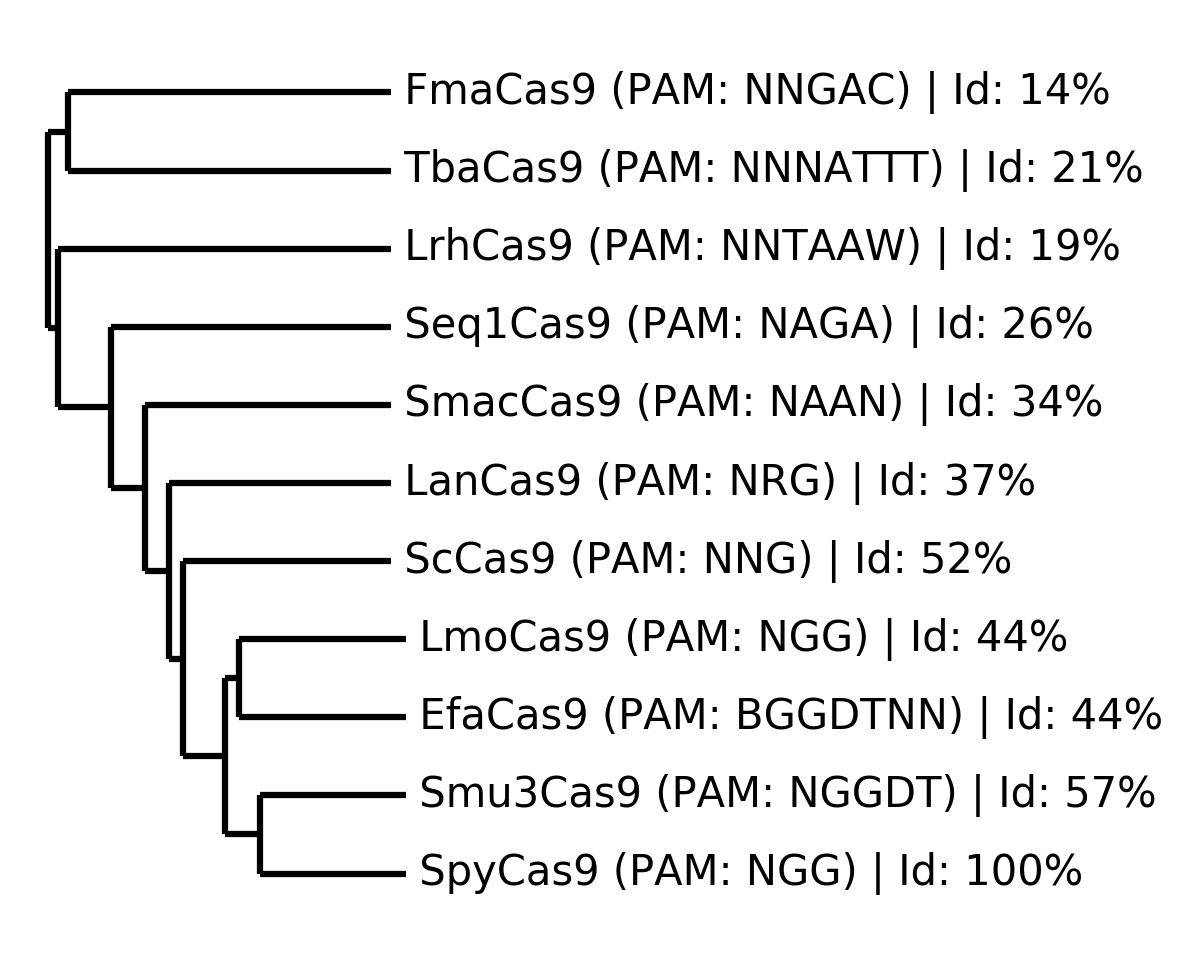

In [141]:
plt.rcParams["figure.figsize"] = (2,4)

Phylo.draw(UGMATree,axis=["off"])

In [164]:
["green" if x<0.5 else "red" for x in data.mcherry.values[order]]

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green']

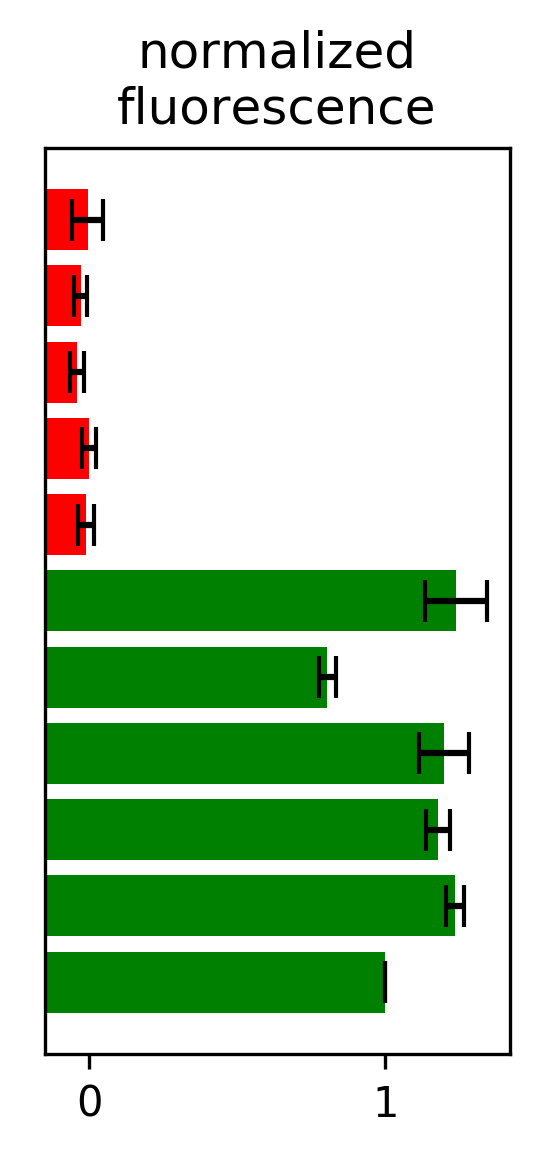

In [187]:
plt.figure()
order = [9,5,4,1,7,8,6,10,3,2,0][::-1]

plt.barh(range(11), data.mcherry.values[order]+0.15, color = ["red" if x<0.5 else "green" for x in data.mcherry.values[order]],
        left = -0.15,  xerr = 2*data.mcherry_std.values[order], ecolor = "black", capsize=5)
#for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["green" if x<0.5 else "red" for x in data.mcherry.values[order]]):
    #ticklabel.set_color(tickcolor)
plt.yticks([],[])
plt.xlabel = ("normalized fluorescence")
plt.title("normalized\nfluorescence")
plt.show()